<a href="https://colab.research.google.com/github/A-Jay04/regression-predict-api-template/blob/master/regression_zindi_challenge/Draft%20Files/Ahmed/Zindi_Ridge_attempt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Now we'll load our data as a Pandas DataFrame

In [0]:
train_df=pd.read_csv('Train.csv')
riders_df=pd.read_csv('Riders.csv')

In [0]:
#Replace spaces with underscores on imported data
train_df.columns=[i.replace(' ','_') for i in train_df.columns]
riders_df.columns=[i.replace(' ','_') for i in riders_df.columns]

In [0]:
#Replace the underscores so OLS can be used later
train_df.columns=[i.replace('_','') for i in train_df.columns]
riders_df.columns=[i.replace('_','') for i in riders_df.columns]

In [0]:
#Replace the dash so OLS can be used later
train_df.columns=[i.replace('-','') for i in train_df.columns]
riders_df.columns=[i.replace('-','') for i in riders_df.columns]

We can take a look at the dimensions of the dataframe to get an idea of the number of rows, _n_, and nummber of predictors, _p_, which is equal to one less than the number of columns.

In [6]:
train_df.shape

(21201, 29)

We need to account for the null values, so we will run a function to check all cols

In [0]:
def total_missing(df):
    #code counts number of nulls and returns a list
    #of percentage null values and column name
    values = []
    rows = len(df)
    for column in df:
      x = ((df[column].isnull().sum())/(rows))*100
      values.append(round(x,3))
    return values

In [8]:
total_missing(train_df)

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 20.593,
 97.396,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [0]:
train_df.drop('Precipitationinmillimeters',axis=1,inplace=True)

In [0]:
train_df["Temperature"].fillna(train_df['Temperature'].median(), inplace=True)

#Dropping logical columns in this following portion

In [0]:
train2_df = train_df.copy()

In [0]:
#Drop Vehicle_Type since all data consists of bikes
train2_df.drop('VehicleType',axis=1,inplace=True)

In [0]:
#Replace Day of Month and Weekday columns with single columns to represent the group of times
train2_df['DayofMonth'] = train2_df['PlacementDayofMonth']
train2_df['Weekday'] = train2_df['ConfirmationWeekday(Mo=1)']

In [0]:
#Drop redundant day of month and weekday columns
train2_df.drop('PlacementDayofMonth',axis=1,inplace=True)
train2_df.drop('PlacementWeekday(Mo=1)',axis=1,inplace=True)
train2_df.drop('ConfirmationDayofMonth',axis=1,inplace=True)
train2_df.drop('ConfirmationWeekday(Mo=1)',axis=1,inplace=True)
train2_df.drop('ArrivalatPickupDayofMonth',axis=1,inplace=True)
train2_df.drop('ArrivalatPickupWeekday(Mo=1)',axis=1,inplace=True)
train2_df.drop('PickupDayofMonth',axis=1,inplace=True)
train2_df.drop('PickupWeekday(Mo=1)',axis=1,inplace=True)
train2_df.drop('ArrivalatDestinationDayofMonth',axis=1,inplace=True)
train2_df.drop('ArrivalatDestinationWeekday(Mo=1)',axis=1,inplace=True)

#Drop order no and User ID since they do not impact logistics
train2_df.drop('OrderNo',axis=1,inplace=True)
train2_df.drop('UserId',axis=1,inplace=True)

#just for now
#rider_info = train2_df.pop('RiderId')

In [36]:
train2_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21201 entries, 0 to 21200
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   PlatformType              21201 non-null  int64  
 1   PersonalorBusiness        21201 non-null  object 
 2   PlacementTime             21201 non-null  object 
 3   ConfirmationTime          21201 non-null  object 
 4   ArrivalatPickupTime       21201 non-null  object 
 5   PickupTime                21201 non-null  object 
 6   ArrivalatDestinationTime  21201 non-null  object 
 7   Distance(KM)              21201 non-null  int64  
 8   Temperature               21201 non-null  float64
 9   PickupLat                 21201 non-null  float64
 10  PickupLong                21201 non-null  float64
 11  DestinationLat            21201 non-null  float64
 12  DestinationLong           21201 non-null  float64
 13  RiderId                   21201 non-null  object 
 14  Timefr

We will know add categorical values next

In [0]:
time=[]

for i in range(len(train2_df['PickupTime'])):

  idx=train2_df['PickupTime'][i].index(':')

  if train2_df['PickupTime'][i][-2:]=='AM' and int(train2_df['PickupTime'][i][:idx]) in [3,4,5,6,7,8,9]:
    time.append('EarlyMorning')
  elif train2_df['PickupTime'][i][-2:]=='AM' and int(train2_df['PickupTime'][i][:idx]) in [10,11]:
    time.append('LateMorning')
  elif train2_df['PickupTime'][i][-2:]=='PM' and int(train2_df['PickupTime'][i][:idx]) in [12,1,2,3]:
    time.append('EarlyAfternoon')
  elif train2_df['PickupTime'][i][-2:]=='PM' and int(train2_df['PickupTime'][i][:idx]) in [4,5,6,7]:
    time.append('Late')
  elif train2_df['PickupTime'][i][-2:]=='AM':
    time.append('EarlyMorning')
  else:
    time.append('EarlyAfternoon')


train2_df['PickupTime']=time

In [0]:
#Drop Timestamp columns

train2_df.drop('PlacementTime',axis=1,inplace=True)
train2_df.drop('ConfirmationTime',axis=1,inplace=True)
train2_df.drop('ArrivalatPickupTime',axis=1,inplace=True)
train2_df.drop('ArrivalatDestinationTime',axis=1,inplace=True)

In [39]:
train2_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21201 entries, 0 to 21200
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   PlatformType             21201 non-null  int64  
 1   PersonalorBusiness       21201 non-null  object 
 2   PickupTime               21201 non-null  object 
 3   Distance(KM)             21201 non-null  int64  
 4   Temperature              21201 non-null  float64
 5   PickupLat                21201 non-null  float64
 6   PickupLong               21201 non-null  float64
 7   DestinationLat           21201 non-null  float64
 8   DestinationLong          21201 non-null  float64
 9   RiderId                  21201 non-null  object 
 10  TimefromPickuptoArrival  21201 non-null  int64  
 11  DayofMonth               21201 non-null  int64  
 12  Weekday                  21201 non-null  int64  
dtypes: float64(5), int64(5), object(3)
memory usage: 2.1+ MB


DUMMY VARIABLE SECTION

In [0]:
dummy_df = pd.get_dummies(train2_df,columns=['PickupTime', 'PersonalorBusiness','PlatformType'], drop_first=1 )

In [41]:
dummy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21201 entries, 0 to 21200
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Distance(KM)                 21201 non-null  int64  
 1   Temperature                  21201 non-null  float64
 2   PickupLat                    21201 non-null  float64
 3   PickupLong                   21201 non-null  float64
 4   DestinationLat               21201 non-null  float64
 5   DestinationLong              21201 non-null  float64
 6   RiderId                      21201 non-null  object 
 7   TimefromPickuptoArrival      21201 non-null  int64  
 8   DayofMonth                   21201 non-null  int64  
 9   Weekday                      21201 non-null  int64  
 10  PickupTime_EarlyMorning      21201 non-null  uint8  
 11  PickupTime_Late              21201 non-null  uint8  
 12  PickupTime_LateMorning       21201 non-null  uint8  
 13  PersonalorBusine

In [0]:
spare = dummy_df.pop('TimefromPickuptoArrival')

In [0]:
dummy_df['TimefromPickuptoArrival'] = spare

In [0]:
#KM making issues so we will remove it
dummy_df.rename(columns={"Distance(KM)": "Distance"}, inplace=True)

In [0]:
dummy_df.info()

We will fork at this point - so we have one dataframe with only test data and another that holds a merge with the riders table so we can compare the two

In [0]:
single_df = dummy_df.copy()

In [0]:
train_join = dummy_df.copy()

In [0]:
#Innner join Train_df and Rider_df on Rider_Id
#you are changing the df by using merge
#use a left join to ensure train data stays

join_df=pd.merge(train_join,riders_df,how='left',on='RiderId')

Lets check both dataframes for nulls and object types to ensure data integrity

In [0]:
join_df.info()

In [0]:
#we can drop Rider ID now that the join has been made
join_df.drop('RiderId',axis=1,inplace=True)

In [0]:
single_df.drop('RiderId',axis=1,inplace=True)

In [0]:
#we need to reorder so that Y is the last column
spare2 = join_df.pop('TimefromPickuptoArrival')
join_df['TimefromPickuptoArrival'] = spare2

# NEXT CELL HOLDS A MERGED DATAFRAME READY TO USE

In [0]:
#join_df

# NEXT CELL HOLDS AN UNMERGED DATAFRAME READY TO USE

In [0]:
#single_df

# **Following section continues to scaling of UNMERGED DF**

We will be using a dataset which contains monthly data for the Rand/Dollar exchange rate, as well as a few potential predictor variables. In this case, the goal is to try and model the exchange rate, using the other 19 variables.   

The way we write this is as follows:   

$$Y = \beta_0 + \beta_1X_1 + \beta_2X_2 + ... + \beta_pX_p$$   

In this case, $Y$ is the reponse variable which depends on the _p_ predictor variables.

### Review of Data Scaling

The regularization techniques we will cover in the course require that our variables are appropriately scaled. As we have seen, Z-score standardisation is a great way to scale variables such that they have similar (though not identical) ranges, in a way that is fairly robust to outlier values.

We'll import the `StandardScalar()` object from `sklearn.preprocessing`.

In [0]:
# split data into predictors and response
# THIS X AND Y VALUE ARE BASED ON UNMERGED DATAFRAME AND THEREFORE IS NOT THE SAME AS THE MERGE ONE. X COLS WILL DIFFER
X = single_df.drop('TimefromPickuptoArrival', axis=1)
y = single_df['TimefromPickuptoArrival']

In [0]:
# import scaler method from sklearn
from sklearn.preprocessing import StandardScaler

In [0]:
# create scaler object
scaler = StandardScaler()

In [0]:
# create scaled version of the predictors (there is no need to scale the response)
X_scaled = scaler.fit_transform(X)

In [64]:
# convert the scaled predictor values into a dataframe
X_standardise = pd.DataFrame(X_scaled,columns=X.columns)
X_standardise.head()

,Distance,Temperature,PickupLat,PickupLong,DestinationLat,DestinationLong,DayofMonth,Weekday,PickupTime_EarlyMorning,PickupTime_Late,PickupTime_LateMorning,PersonalorBusiness_Personal,PlatformType_2,PlatformType_3,PlatformType_4
0,-0.971370,-0.902320,-1.189424,0.509897,-0.511888,0.414159,-0.756213,1.122885,-0.325051,-0.451195,1.770412,-0.468583,-0.220146,0.417505,-0.030729
1,1.145469,0.959066,-2.294056,2.349813,-0.356757,0.070177,-0.415254,1.122885,-0.325051,-0.451195,1.770412,2.134095,-0.220146,0.417505,-0.030729
2,-1.147774,0.059396,-0.878981,0.858136,-0.526672,0.379588,1.630501,-0.791368,-0.325051,-0.451195,-0.564840,-0.468583,-0.220146,0.417505,-0.030729
3,-0.089354,-1.274597,0.005523,0.563962,0.730374,-0.361289,-0.074294,1.122885,3.076437,-0.451195,-0.564840,-0.468583,-0.220146,0.417505,-0.030729
4,-0.089354,-2.453475,0.487515,-0.510932,-0.357811,-0.031369,-0.301601,-1.429452,-0.325051,-0.451195,1.770412,2.134095,-0.220146,-2.395181,-0.030729


## Ridge Regression
We will first split our data into a training and a testing set. We'll use the first eight years of data as our training set and test the model on the final two years. Note that with time-series data it isn't appropriate to sample rows randomly for the training and testing sets because chronological order remains important.

Fitting and testing a Ridge Regression model is very similar to multiple variable regression in `sklearn`. For now, we are going to create a `Ridge()` object without modifying any of the parameters. This means that we will use the default value of $\alpha=1$. In a later tutorial, we'll learn about choosing a better value for this hyperparameter.

In [0]:
# import train/test splitting function from sklearn
from sklearn.model_selection import train_test_split

In [0]:
# split the data into train and test, being sure to use the standardised predictors
X_train, X_test, y_train, y_test = train_test_split(X_standardise, 
                                                    y, 
                                                    test_size=0.2, 
                                                    shuffle=False)

In [0]:
# import the ridge regression module from sklearn
from sklearn.linear_model import Ridge

In [0]:
# create ridge model
ridge = Ridge()

In [69]:
# train the model
ridge.fit(X_train, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [0]:
# extract the model intercept value
b0 = float(ridge.intercept_)

In [0]:
# extract the model coefficient value
coeff = pd.DataFrame(ridge.coef_, X.columns, columns=['Coefficient'])

In [72]:
print("Intercept:", float(b0))

Intercept: 1559.885192120236


In [73]:
# check out the coefficients
coeff

,Coefficient
Distance,581.029750
Temperature,-7.988790
PickupLat,11.148685
PickupLong,-36.883774
DestinationLat,-15.749491
DestinationLong,-5.222538
DayofMonth,-12.206075
Weekday,10.430631
PickupTime_EarlyMorning,-38.572993
PickupTime_Late,-4.066041


### Interpretation of the intercept and coefficients

Because we standardised the features, we interpret the intercept slightly differently than in the case of multiple variable linear regression. Previously it was the expected Dollar/Rand exchange rate when all feature values are set to zero. Now, since the standardised features are all centered around zero, the intercept can be interpreted as the expected exchange rate when all the features are equal to their respective means. 

As with the intercept, the coefficients also have a different interpretation. Previously (without standardisation) it was the expected change in exchange rate given an increase of 1 unit in the feature value. Now (with standardisation) it is the expected change in exchange rate given an increase of 1 in the **scaled feature value**.

The advantage here is that it becomes easier to compare coefficients to eachother, since their respective variables are all on the same scale. Now, variables with smaller coefficients are less important - they have suffered more in the shrinkage tradeoff.

## Assessment of predictive accuracy
We can make use of the `sklearn.metrics` library to assess the accuracy of our model. For comparison, we'll fit a linear model (without regularization) to the data.

In [74]:
# fit a basic linear model
from sklearn.linear_model import LinearRegression

# create model object
lm = LinearRegression()

# train model
lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [0]:
# import metrics module
from sklearn import metrics

In [76]:
# check training accuracy
train_lm = lm.predict(X_train)
train_ridge = ridge.predict(X_train)

print('Training MSE')
print('Linear:', metrics.mean_squared_error(y_train, train_lm))
print('Ridge :', metrics.mean_squared_error(y_train, train_ridge))

Training MSE
Linear: 650958.1815395305
Ridge : 650958.1828533922


In [77]:
test_lm = lm.predict(X_test)
test_ridge = ridge.predict(X_test)

print('Testing MSE')
print('Linear:', metrics.mean_squared_error(y_test, test_lm))
print('Ridge :', metrics.mean_squared_error(y_test, test_ridge))

Testing MSE
Linear: 606066.4315508766
Ridge : 606066.8408392238


We can see that Ridge regression achieves a much lower score on the testing set at the expense of a slightly higher score on the training set. The increase in training MSE is not anything to be worried about since we want to avoid overfitting on the training set.   

As a final step, let's plot our results.

In [89]:
y_test.head()

16960    1143
16961    3115
16962    2124
16963    1840
16964     764
Name: TimefromPickuptoArrival, dtype: int64

In [0]:
# we want to plot the train and test response variables as a continuous line
train_plot = y_train.append(pd.Series(y_test[16960], index=['2016M01']))

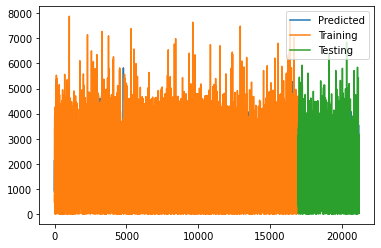

In [91]:
plt.plot(np.arange(len(y)), ridge.predict(X_standardise), label='Predicted')
plt.plot(np.arange(len(train_plot)), train_plot, label='Training')
plt.plot(np.arange(len(y_test))+len(y_train), y_test, label='Testing')
plt.legend()

plt.show()

# **Repeat of above using the merged dataframe**

NOTE: the variables are the same so the cells need to be run from this point all the way to the end (i copy pasted the above and then just changed the first df we start at)


### Review of Data Scaling

The regularization techniques we will cover in the course require that our variables are appropriately scaled. As we have seen, Z-score standardisation is a great way to scale variables such that they have similar (though not identical) ranges, in a way that is fairly robust to outlier values.

We'll import the `StandardScalar()` object from `sklearn.preprocessing`.

In [0]:
# split data into predictors and response
# THIS X AND Y VALUE ARE BASED ON MERGED DATAFRAME AND THEREFORE IS NOT THE SAME AS THE UNMERGE ONE. X COLS WILL DIFFER
X = join_df.drop('TimefromPickuptoArrival', axis=1)
y = join_df['TimefromPickuptoArrival']

In [0]:
# import scaler method from sklearn
from sklearn.preprocessing import StandardScaler

In [0]:
# create scaler object
scaler = StandardScaler()

In [0]:
# create scaled version of the predictors (there is no need to scale the response)
X_scaled = scaler.fit_transform(X)

In [96]:
# convert the scaled predictor values into a dataframe
X_standardise = pd.DataFrame(X_scaled,columns=X.columns)
X_standardise.head()

,Distance,Temperature,PickupLat,PickupLong,DestinationLat,DestinationLong,DayofMonth,Weekday,PickupTime_EarlyMorning,PickupTime_Late,PickupTime_LateMorning,PersonalorBusiness_Personal,PlatformType_2,PlatformType_3,PlatformType_4,NoOfOrders,Age,AverageRating,NoofRatings
0,-0.971370,-0.902320,-1.189424,0.509897,-0.511888,0.414159,-0.756213,1.122885,-0.325051,-0.451195,1.770412,-0.468583,-0.220146,0.417505,-0.030729,-0.035206,0.501451,-0.090082,0.516144
1,1.145469,0.959066,-2.294056,2.349813,-0.356757,0.070177,-0.415254,1.122885,-0.325051,-0.451195,1.770412,2.134095,-0.220146,0.417505,-0.030729,-0.823507,-0.998616,-0.308411,-0.675342
2,-1.147774,0.059396,-0.878981,0.858136,-0.526672,0.379588,1.630501,-0.791368,-0.325051,-0.451195,-0.564840,-0.468583,-0.220146,0.417505,-0.030729,-0.425228,-1.148623,-1.509220,-0.563640
3,-0.089354,-1.274597,0.005523,0.563962,0.730374,-0.361289,-0.074294,1.122885,3.076437,-0.451195,-0.564840,-0.468583,-0.220146,0.417505,-0.030729,-0.512252,-1.085218,0.674069,-0.566123
4,-0.089354,-2.453475,0.487515,-0.510932,-0.357811,-0.031369,-0.301601,-1.429452,-0.325051,-0.451195,1.770412,2.134095,-0.220146,-2.395181,-0.030729,0.392929,-0.174352,0.237411,0.476428


## Ridge Regression
We will first split our data into a training and a testing set. We'll use the first eight years of data as our training set and test the model on the final two years. Note that with time-series data it isn't appropriate to sample rows randomly for the training and testing sets because chronological order remains important.

Fitting and testing a Ridge Regression model is very similar to multiple variable regression in `sklearn`. For now, we are going to create a `Ridge()` object without modifying any of the parameters. This means that we will use the default value of $\alpha=1$. In a later tutorial, we'll learn about choosing a better value for this hyperparameter.

In [0]:
# import train/test splitting function from sklearn
from sklearn.model_selection import train_test_split

In [0]:
# split the data into train and test, being sure to use the standardised predictors
X_train, X_test, y_train, y_test = train_test_split(X_standardise, 
                                                    y, 
                                                    test_size=0.2, 
                                                    shuffle=False)

In [0]:
# import the ridge regression module from sklearn
from sklearn.linear_model import Ridge

In [0]:
# create ridge model
ridge = Ridge()

In [101]:
# train the model
ridge.fit(X_train, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [0]:
# extract the model intercept value
b0 = float(ridge.intercept_)

In [0]:
# extract the model coefficient value
coeff = pd.DataFrame(ridge.coef_, X.columns, columns=['Coefficient'])

In [104]:
print("Intercept:", float(b0))

Intercept: 1559.6270465319694


In [105]:
# check out the coefficients
coeff

,Coefficient
Distance,580.422558
Temperature,-3.184437
PickupLat,7.868672
PickupLong,-36.057233
DestinationLat,-15.730599
DestinationLong,-7.557044
DayofMonth,-10.504510
Weekday,9.209696
PickupTime_EarlyMorning,-33.552484
PickupTime_Late,-3.075259


### Interpretation of the intercept and coefficients

Because we standardised the features, we interpret the intercept slightly differently than in the case of multiple variable linear regression. Previously it was the expected Dollar/Rand exchange rate when all feature values are set to zero. Now, since the standardised features are all centered around zero, the intercept can be interpreted as the expected exchange rate when all the features are equal to their respective means. 

As with the intercept, the coefficients also have a different interpretation. Previously (without standardisation) it was the expected change in exchange rate given an increase of 1 unit in the feature value. Now (with standardisation) it is the expected change in exchange rate given an increase of 1 in the **scaled feature value**.

The advantage here is that it becomes easier to compare coefficients to eachother, since their respective variables are all on the same scale. Now, variables with smaller coefficients are less important - they have suffered more in the shrinkage tradeoff.

## Assessment of predictive accuracy
We can make use of the `sklearn.metrics` library to assess the accuracy of our model. For comparison, we'll fit a linear model (without regularization) to the data.

In [106]:
# fit a basic linear model
from sklearn.linear_model import LinearRegression

# create model object
lm = LinearRegression()

# train model
lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [0]:
# import metrics module
from sklearn import metrics

In [108]:
# check training accuracy
train_lm = lm.predict(X_train)
train_ridge = ridge.predict(X_train)

print('Training MSE')
print('Linear:', metrics.mean_squared_error(y_train, train_lm))
print('Ridge :', metrics.mean_squared_error(y_train, train_ridge))

Training MSE
Linear: 642605.9846792299
Ridge : 642605.9868478872


In [109]:
test_lm = lm.predict(X_test)
test_ridge = ridge.predict(X_test)

print('Testing MSE')
print('Linear:', metrics.mean_squared_error(y_test, test_lm))
print('Ridge :', metrics.mean_squared_error(y_test, test_ridge))

Testing MSE
Linear: 599571.2586487111
Ridge : 599571.1722232085


We can see that Ridge regression achieves a much lower score on the testing set at the expense of a slightly higher score on the training set. The increase in training MSE is not anything to be worried about since we want to avoid overfitting on the training set.   

As a final step, let's plot our results.

In [110]:
y_test

16960    1143
16961    3115
16962    2124
16963    1840
16964     764
         ... 
21196       9
21197     770
21198    2953
21199    1380
21200    2128
Name: TimefromPickuptoArrival, Length: 4241, dtype: int64

In [0]:
# we want to plot the train and test response variables as a continuous line
train_plot = y_train.append(pd.Series(y_test[16960], index=['2016M01']))

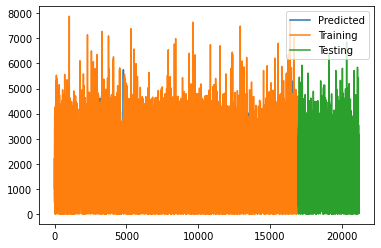

In [112]:
plt.plot(np.arange(len(y)), ridge.predict(X_standardise), label='Predicted')
plt.plot(np.arange(len(train_plot)), train_plot, label='Training')
plt.plot(np.arange(len(y_test))+len(y_train), y_test, label='Testing')
plt.legend()

plt.show()